In [10]:
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
import os
from PIL import Image
import rasterio
import time
import json
from graph_tool.all import *

In [13]:
from power_planner.utils import *

## Next meeting:

* path straightening in constraints notebook with algorithm is not an actual straightening

### Explain pipeline:

* Get hard constraints --> binary corridor, + water etc
* Add one node to the graph for each raster cell in the corridor
* Define donut around each cell
* Add edges between each point and the point in the donut around it, with weights:
    * First option: sum of cost of both cells of these two nodes
    * Second option: sum of cost of all cells inbetween --> Bresenham line (other notebook)
* Add start and end node, and connect to the top x and bottom x points of the corridor with weight 0
* Run shortest path algorithm (bellman ford)

So far: downscaling with different factors

### Runtimes:

**Scale by 5 --> 20 poins in donut**
* edge convolutions: {'init_graph': 0.03, 'add_nodes': 1.676, **'edge_list (per convolution!)': 0.9, 'add_edges (per shift)': 0.0045**, 'start_end_vertex': 0.004, 'shortest_path': 0.363}
* node adding: {'init_graph': 0.03, 'add_nodes': 1.376, **'edge_list': 0.00245, 'add_edges': 0.00665,** 'start_end_vertex': 0.005, 'shortest_path': 0.236}
* old edge version {'init_graph': 0.031, 'add_nodes': 1.481, **'edge_list': 0.198, 'add_edges': 0.045**, 'start_end_vertex': 0.003, 'shortest_path': 0.216}

--> add adges even longer if list not split?!, improved node constraints by factor of 80

**networkx scale 5:**
* bellman ford: {'init_graph': 0.037, 'add_nodes': 0.03, 'edge_list': 0.002, **'add_edges': 0.2996**, 'start_end_vertex': 0.007, **'shortest_path': 2.961**}
* dijkstra: {'init_graph': 0.036, 'add_nodes': 0.03, 'edge_list': 0.0020000000000000005, 'add_edges': 0.2926000000000001, 'start_end_vertex': 0.004, 'shortest_path': 0.633}

--> graph-tool speed up: shortest path 10 times (bellman ford), 2 times (dijkstra), adding edges 60 times

**Scale by 2 --> 156 point in donut**
* edge convolutions with **faster convolutions**: {'init_graph': 0.233, 'add_nodes': 0.005, 'concatenate': 0.328, 'add_edges': 0.025, **'edge_list': 0.15**, 'start_end_vertex': 0.015, 'shortest_path': 27.296}
* edge convolutions: {'init_graph': 0.198, 'add_nodes': 9.569, **'edge_list': 6.908, 'add_edges': 0.0273**, 'start_end_vertex': 0.034, 'shortest_path': 32.844}
* node adding: {'init_graph': 0.202, 'add_nodes': 9.458, **'edge_list': 0.0092, 'add_edges': 0.024,** 'start_end_vertex': 0.017, 'shortest_path': 7.76}
* node adding graph tool dijkstra: {'init_graph': 0.274, 'add_nodes': 0.006, 'edge_list': 0.010, 'add_edges': 0.029, 'start_end_vertex': 0.018, **'shortest_path': 0.822**}
* old edge version: {'init_graph': 0.206, 'add_nodes': 10.979, **'edge_list': 1.154, 'add_edges': 0.314,** 'start_end_vertex': 0.032, 'shortest_path': 7.492}
* networkx dijkstra: {'init_graph': 0.212, 'add_nodes': 0.156, 'edge_list': 0.01, **'add_edges': 3.08,** 'start_end_vertex': 0.065, **'shortest_path': 41.075**}

--> speed up of node constraint by factor of 125
--> graph tool speedup: 6 times for shortest path, 

**Whole instance: 428643 nodes --> around 263 615 445 edges**
* dijkstra does not work because out of memory, time is {'init_graph': 0.624, 'add_nodes': 0.021, 'edge_list': 0.065,**'add_edges': 1.179**, 'start_end_vertex': 0.61,**'shortest_path': 611.761**}
* with adding all edges at ones (bellman ford graph-tool): crashed 


**Directed graph:**
* speed up for shortest path by a lot! 
* scale 2 directed: 0.5 
* {'init_graph': 0.218, 'add_nodes': 0.005, 'add_edges': 0.024, 'edge_list': 0.12, **'shortest_path': 0.518**}
* scale 2 undirected: 8

**Other observations:**
* graph-tool becomes slower for adding edges, the more edges are in the graph already
* graph-tool with adding all edges at once: {'init_graph': 0.211, 'add_nodes': 0.005, 'add_edges': 0.026, 'edge_list': 0.017, 'start_end_vertex': 0.007, 'shortest_path': 6.554}
* **add_nodes is much faster when no generator is returned (and seems to work just as fine**

### Space efficiency:

* with dijkstra my laptop crashed, with bellman ford it's okay (for full instance --> 249 000 000 edges)
* scaled 2 still fine 15 912 513 edges

### Discuss:

* Angle constraints: 
    * Path straightening (other notebook) is actually sampling fewer points
    * Line graph takes m*1/3 d

### Questions:

Pipeline so far:

* Normalization: 0-1 normalization for cost surface?
* Bresenham line makes sense?
* Start and end node given? first row?
* networkx version

Constraints:

* Hard constraints: Distance from towns etc? Water?
* View on towers / cables constraint?
* Height of towers
* Monetary costs? --> node costs in addition, so it's not placing too many towers

How to use other tifs?? - Excel sheet

### meeting:

* infinity costs on edges for NaNs
* function to compute resistance: multiply raster tifs with weights
* the more negative the value, the more suitable
* completely forbidden: NaN or infinite
* MCDA negative values - but zickszack

Todo:
* flip coordinates

In [2]:
with open("../outputs/path_whole_instance_infos.json","r") as infile:
    infos = json.load(infile)

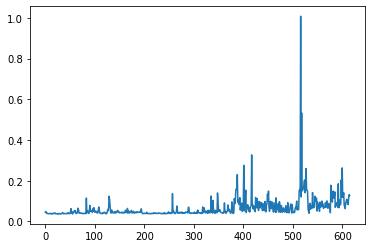

In [9]:
plt.plot(infos["time_logs"]["edge_list_times"])
plt.show()

## Start and end

In [275]:
path_files = "/Users/ninawiedemann/Downloads/tif_ras_buf"

In [283]:
with rasterio.open(os.path.join(path_files, "corridor/CORRIDOR_BE.tif")) as dataset:
    # "/Users/ninawiedemann/Downloads/tifs_new/Destination.tif", 'r') as dataset:
    print(dataset.width)
    print(dataset.bounds)
    transform_matrix = dataset.transform
    arr = dataset.read()
    print(arr.shape)

1511
BoundingBox(left=163246.2068, bottom=126131.1214, right=178356.2068, top=139261.1214)
(1, 1313, 1511)


In [284]:
~transform_matrix*(167956.27305673048, 127231.34509884659)

(471.0066256730479, 1202.9776301153415)

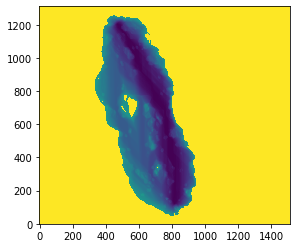

In [294]:
plt.imshow(arr[0], origin="lower")
plt.show()

In [295]:
arr[0, 1202, 471]

8222.764660044888

In [258]:
import shapefile
sf = shapefile.Reader("/Users/ninawiedemann/Downloads/tifs_new/Destination")

In [269]:
shapes = sf.shapes()

In [272]:
shapes[0].points

[[167956.27305673048, 127231.34509884659]]

In [251]:
# np.unique(arr)
np.where(arr==1)

(array([0]), array([22]), array([94]))

## Optimize convolution

In [16]:
import numpy as np

from power_planner.utils import get_half_donut


def bresenham_line(x0, y0, x1, y1):
    """
    find pixels on line between two pixels
    https://stackoverflow.com/questions/50995499/generating-pixel-values-of-line-connecting-2-points
    """
    steep = abs(y1 - y0) > abs(x1 - x0)
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1

    switched = False
    if x0 > x1:
        switched = True
        x0, x1 = x1, x0
        y0, y1 = y1, y0

    if y0 < y1:
        ystep = 1
    else:
        ystep = -1

    deltax = x1 - x0
    deltay = abs(y1 - y0)
    error = -deltax / 2
    y = y0

    line = []
    for x in range(x0, x1 + 1):
        if steep:
            line.append([y, x])
        else:
            line.append([x, y])

        error = error + deltay
        if error > 0:
            y = y + ystep
            error = error - deltax
    if switched:
        line.reverse()
    return line


def get_kernel(shifts):
    """
    Get all kernels describing the path of the edges in a discrete raster
    :param shifts: possible circle points
    :returns kernel: all possible kernels (number of circle points x upper x upper)
    :returns posneg: a list indicating whether it is a path to the left (=1) or to the right(=0)
    """
    upper = np.amax(np.absolute(shifts)) + 1
    posneg = []
    kernel = np.zeros((len(shifts), upper, upper))

    for i, shift in enumerate(shifts):
        if shift[1] < 0:
            posneg.append(1)
            line = bresenham_line(0, upper - 1, shift[0], upper - 1 + shift[1])
        else:
            posneg.append(0)
            line = bresenham_line(0, 0, shift[0], shift[1])
        # add points of line to the kernel
        for (j, k) in line:
            kernel[i, j, k] += 1
    return kernel, posneg


def convolve(img, kernel, neg=0):
    """
    Convolve a 2d img with a kernel, storing the output in the cell 
    corresponding the the left or right upper corner 
    :param img: 2d numpy array
    :param kernel: kernel (must have equal size and width)
    :param neg: if neg=0, store in upper left corner, if neg=1, store in upper 
    right corner
    :return convolved image of same size
    """
    k_size = len(kernel)
    if neg:
        padded = np.pad(img, ((0, k_size - 1), (k_size - 1, 0)))
    else:
        padded = np.pad(img, ((0, k_size), (0, k_size)))
    # print(padded.shape)
    convolved = np.zeros(img.shape)
    w, h = img.shape
    for i in range(0, w):
        for j in range(0, h):
            patch = padded[i:i + k_size, j:j + k_size]
            convolved[i, j] = np.sum(patch * kernel)
    return convolved


def angle(path):
    path = np.asarray(path)
    for p, (i, j) in enumerate(path[:-2]):
        v1 = path[p + 1] - path[p]
        v2 = path[p + 1] - path[p + 2]
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        angle = np.arccos(np.dot(v1, v2))
        if angle < np.pi:
            pass


# Questions:
## altitude leads to more costs for pylons? because they are higher?

# height profile constraints:
## simply exclude edges which cannot be placed --> only works when iterating over edges

## Angle constraints:
# * line graph
# * path straighening toolbox


In [14]:
arr = np.arange(0,81,1).reshape((9,9))
arr

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44],
       [45, 46, 47, 48, 49, 50, 51, 52, 53],
       [54, 55, 56, 57, 58, 59, 60, 61, 62],
       [63, 64, 65, 66, 67, 68, 69, 70, 71],
       [72, 73, 74, 75, 76, 77, 78, 79, 80]])

In [210]:
shifts = get_half_donut(3, 8)
kernel, posneg = get_kernel(shifts)

In [225]:
kernel[14]

array([[0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [227]:
convolve(arr, kernel[14], 1)

array([[  0.,   1.,  12.,  24.,  37.,  51.,  75., 100., 108.],
       [  9.,  19.,  39.,  60.,  82., 105., 138., 172., 180.],
       [ 18.,  37.,  66.,  96., 127., 159., 201., 244., 252.],
       [ 27.,  55.,  93., 132., 172., 213., 264., 316., 324.],
       [ 36.,  73., 120., 168., 217., 267., 327., 388., 396.],
       [ 45.,  91., 147., 204., 262., 321., 390., 460., 468.],
       [ 54., 109., 174., 240., 307., 375., 453., 532., 540.],
       [ 63., 127., 201., 276., 352., 429., 435., 441., 447.],
       [ 72., 145., 147., 149., 151., 153., 155., 157., 159.]])

In [26]:
from scipy.signal import convolve2d

In [232]:
def convolve_faster(img, f, neg):
    k_size = len(f)
    # a = np.pad(img, ((0, k_size-1), (0, k_size-1)))
    if neg:
        padded = np.pad(img, ((0, k_size - 1), (k_size - 1, 0)))
    else:
        padded = np.pad(img, ((0, k_size - 1), (0, k_size - 1)))
    
    s = f.shape + tuple(np.subtract(padded.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(padded, shape = s, strides = padded.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

In [233]:
arr2 = convolve_faster(arr, kernel[14], 1) # [5:-2, 2:-5] # 8x8
# [3:-6, 9:] # for 10x10 kernel, 1:-3,3:-1] # for 5x5 kernel

In [234]:
arr2

array([[  0.,   1.,  12.,  24.,  37.,  51.,  75., 100., 108.],
       [  9.,  19.,  39.,  60.,  82., 105., 138., 172., 180.],
       [ 18.,  37.,  66.,  96., 127., 159., 201., 244., 252.],
       [ 27.,  55.,  93., 132., 172., 213., 264., 316., 324.],
       [ 36.,  73., 120., 168., 217., 267., 327., 388., 396.],
       [ 45.,  91., 147., 204., 262., 321., 390., 460., 468.],
       [ 54., 109., 174., 240., 307., 375., 453., 532., 540.],
       [ 63., 127., 201., 276., 352., 429., 435., 441., 447.],
       [ 72., 145., 147., 149., 151., 153., 155., 157., 159.]])

In [ ]:
def convolve_faster(img, kernel, neg):
    k_size = len(kernel)
    print(k_size)
    # print(k_size)
    # if neg:
    #     padded = np.pad(img, ((0, k_size - 1), (k_size - 1, 0)))
    # else:
    #     padded = np.pad(img, ((0, k_size), (0, k_size)))
    padded = np.pad(img, ((0, k_size), (0, k_size)))
    print(padded.astype(int))
    print(kernel)
    return convolve2d(padded, kernel, mode ="same")[:-k_size-4, :-k_size-4]
# 8x8: [1:-k_size+1, 1:-k_size+1] 
# 7x7 [2:-k_size+2, :-k_size]
# 6x6 [3:-k_size+3, 1:-k_size+1]
# 5x5 

In [197]:
arr2

array([[ 147.,  195.,  247.,  267.,  287.],
       [ 258.,  345.,  437.,  462.,  487.],
       [ 396.,  531.,  672.,  702.,  732.],
       [ 558.,  747.,  942.,  972., 1002.],
       [ 720.,  963., 1212., 1242., 1272.]])

In [82]:
kernel[33].shape

(10, 10)